## **Libraries**

In [1]:
# === IMPORTS ===
import os
import re
import string
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, silhouette_score, adjusted_rand_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from xgboost import XGBClassifier
from joblib import Parallel, delayed

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

## **Import the Data**

In [2]:
# === DATASET DOWNLOAD & LOADING ===
import kagglehub

# Download dataset and get local path
dataset_path = kagglehub.dataset_download("alexandrakim2201/spotify-dataset")
print("Path to dataset files:", dataset_path)

# List files in dataset folder and find CSV file
files = os.listdir(dataset_path)
print("Available files:", files)

csv_files = [f for f in files if f.endswith(".csv")]

if csv_files:
    data_file_path = os.path.join(dataset_path, csv_files[0])
    data = pd.read_csv(data_file_path)
    print("Dataset loaded successfully!")
    print(data.head())

    # Save a copy locally
    data.to_csv("spotify_dataset_saved.csv", index=False)
    print("Dataset saved as spotify_dataset_saved.csv")
else:
    raise FileNotFoundError("No CSV file found in the dataset.")

Path to dataset files: /kaggle/input/spotify-dataset
Available files: ['DATASET.csv']
Dataset loaded successfully!
                                              Review     label
0  Great music service, the audio is high quality...  POSITIVE
1  Please ignore previous negative rating. This a...  POSITIVE
2  This pop-up "Get the best Spotify experience o...  NEGATIVE
3    Really buggy and terrible to use as of recently  NEGATIVE
4  Dear Spotify why do I get songs that I didn't ...  NEGATIVE
Dataset saved as spotify_dataset_saved.csv


## **Exploring the Data**

In [4]:
# === DATA EXPLORATION ===

print("\nDataset info:")
data.info()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52702 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  52686 non-null  object
 1   label   52702 non-null  object
dtypes: object(2)
memory usage: 823.6+ KB


In [5]:
print("\nMissing values per column:")
print(data.isnull().sum())


Missing values per column:
Review    16
label      0
dtype: int64


In [6]:
# Drop rows with missing values
data_cleaned = data.dropna()
print("\nMissing values after dropping rows with NaNs:")
print(data_cleaned.isnull().sum())

print(f"\nShape before dropping missing: {data.shape}")
print(f"Shape after dropping missing: {data_cleaned.shape}")


Missing values after dropping rows with NaNs:
Review    0
label     0
dtype: int64

Shape before dropping missing: (52702, 2)
Shape after dropping missing: (52686, 2)


In [7]:
print("\nStatistical description of cleaned data:")
print(data_cleaned.describe())


Statistical description of cleaned data:
       Review     label
count   52686     52686
unique  51472         2
top      Good  NEGATIVE
freq      153     29423


In [8]:
# Check distribution of target labels
label_counts = data_cleaned['label'].value_counts()
print("\nSentiment label distribution:")
print(label_counts)


Sentiment label distribution:
label
NEGATIVE    29423
POSITIVE    23263
Name: count, dtype: int64


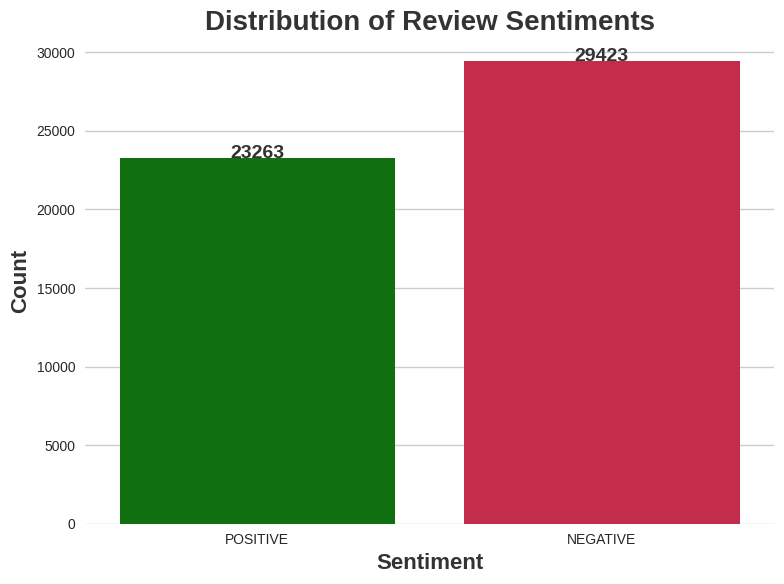

In [11]:
# Plot sentiment distribution
plt.figure(figsize=(8,6))
palette = ['#008000', '#DC143C']  # Emerald green and strawberry red

ax = sns.countplot(x='label', data=data_cleaned, hue='label', palette=palette, dodge=False, legend=False)
plt.title("Distribution of Review Sentiments", fontsize=20, fontweight='bold', color='#333333')
plt.xlabel("Sentiment", fontsize=16, fontweight='bold', color='#333333')
plt.ylabel("Count", fontsize=16, fontweight='bold', color='#333333')

# Add count annotations above bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 15, f'{int(height)}',
            ha='center', fontsize=14, fontweight='bold', color='#333333')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

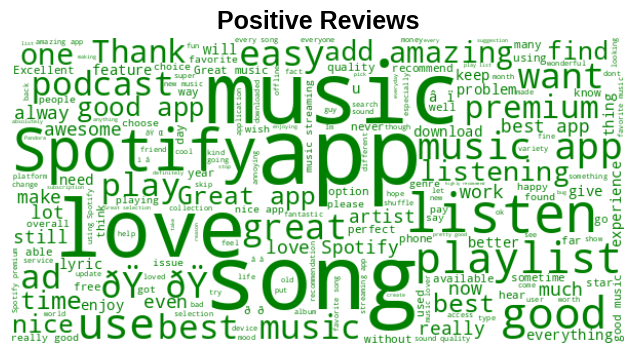

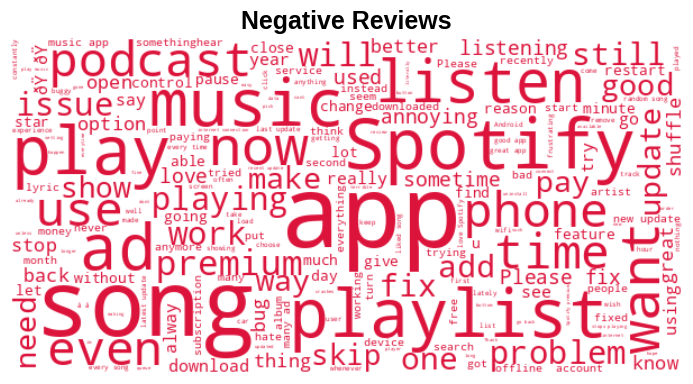

In [12]:
# === WORDCLOUD VISUALIZATION FOR SENTIMENTS ===

# Concatenate all reviews by sentiment
positive_text = ' '.join(data_cleaned[data_cleaned['label'] == 'POSITIVE']['Review'])
negative_text = ' '.join(data_cleaned[data_cleaned['label'] == 'NEGATIVE']['Review'])

# Define custom color functions for word clouds
def emerald_green_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return "#008000"  # Emerald green

def strawberry_red_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return "#DC143C"  # Strawberry red

# Generate word clouds
positive_wordcloud = WordCloud(
    background_color="white",
    max_words=200,
    max_font_size=90,
    width=600,
    height=300,
    contour_width=3,
    contour_color='darkgreen',
    colormap=None
).generate(positive_text)

negative_wordcloud = WordCloud(
    background_color="white",
    max_words=200,
    max_font_size=90,
    width=600,
    height=300,
    contour_width=3,
    contour_color='darkred',
    colormap=None
).generate(negative_text)

# Plot positive word cloud
plt.figure(figsize=(8, 4))
plt.imshow(positive_wordcloud.recolor(color_func=emerald_green_color), interpolation="bilinear")
plt.title("Positive Reviews", fontsize=18, fontweight='bold', color="#000000")
plt.axis("off")

# Plot negative word cloud
plt.figure(figsize=(8, 4))
plt.imshow(negative_wordcloud.recolor(color_func=strawberry_red_color), interpolation="bilinear")
plt.title("Negative Reviews", fontsize=18, fontweight='bold', color="#000000")
plt.axis("off")

plt.tight_layout()
plt.show()

## **Preprocessing the Data**

In [14]:
# === TEXT PREPROCESSING ===

# Download NLTK stopwords if not already present
nltk.download('stopwords')

# Custom stopwords specific to the domain
custom_stopwords = {'spotify', 'music', 'song', 'songs', 'app'}

# Define stopwords set with negation exceptions
stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor', 'never'}

# Merge stopwords with custom ones
all_stopwords = stop_words.union(custom_stopwords)

def clean_text(text):
    """
    Clean and preprocess text by:
    - Removing non-ascii characters
    - Lowercasing
    - Removing punctuation and digits
    - Removing stopwords (with exceptions)
    - Stripping leading and trailing spaces
    """
    # Remove non-ascii characters
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = ''.join([c for c in text if not c.isdigit()])
    # Keep only alphabetic characters and spaces
    text = ''.join(filter(lambda x: x.isalpha() or x.isspace(), text))
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in all_stopwords]
    cleaned_text = ' '.join(tokens)
    # Strip leading and trailing spaces
    return cleaned_text.strip()


# Apply cleaning function to review texts
data_cleaned['Cleaned_Review'] = data_cleaned['Review'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


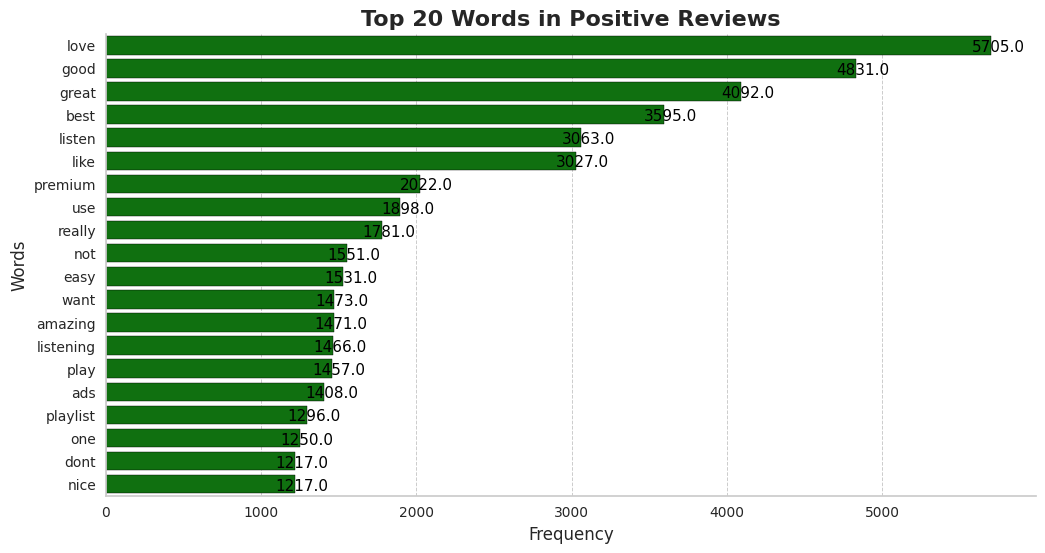

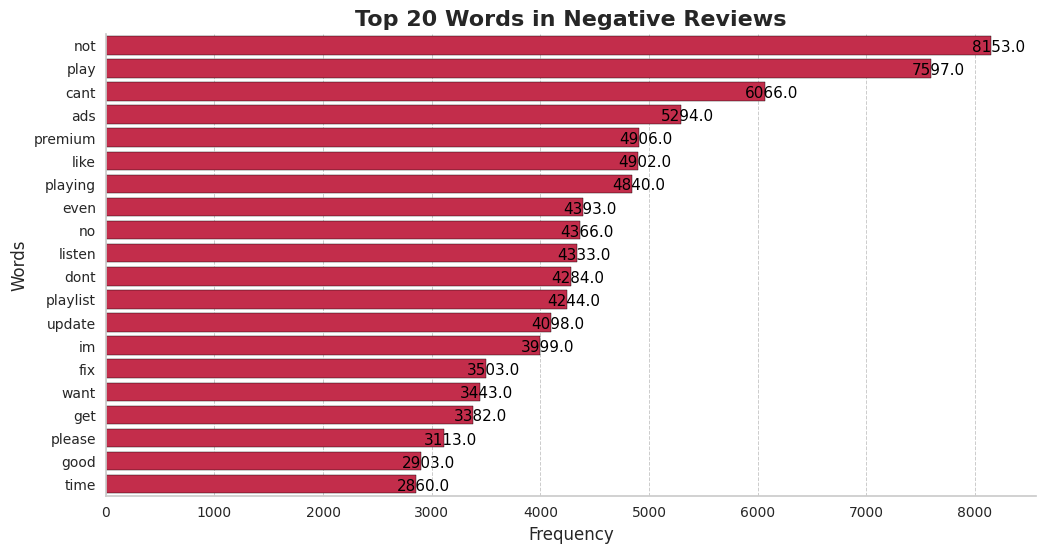

In [16]:
# === TOP WORDS ANALYSIS ===

sns.set_style("whitegrid")

def get_top_words(text_series, n=20):
    """
    Extract top n most frequent words from a series of texts.
    """
    all_words = ' '.join(text_series)
    tokens = all_words.split()
    counter = Counter(tokens)
    return counter.most_common(n)

# Get top 20 words for each sentiment
top_positive = get_top_words(data_cleaned[data_cleaned['label'] == 'POSITIVE']['Cleaned_Review'], 20)
top_negative = get_top_words(data_cleaned[data_cleaned['label'] == 'NEGATIVE']['Cleaned_Review'], 20)

def plot_top_words(top_words, title, color):
    """
    Plot a horizontal bar chart of the most frequent words.
    """
    words, counts = zip(*top_words)
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=list(counts), y=list(words), color=color, edgecolor='black')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Words', fontsize=12)

    # Annotate bars with count values
    for p in ax.patches:
        ax.annotate(f'{p.get_width()}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='center', va='center_baseline', fontsize=11, color='black', xytext=(5, 0),
                    textcoords='offset points')

    sns.despine()
    plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7)
    plt.show()

# Colors for plots
emerald_green = '#008000'
strawberry_red = '#DC143C'

# Plot top words for positive and negative reviews
plot_top_words(top_positive, 'Top 20 Words in Positive Reviews', emerald_green)
plot_top_words(top_negative, 'Top 20 Words in Negative Reviews', strawberry_red)

## **Bag of Words**

In [17]:
# === TEXT REPRESENTATION USING BAG OF WORDS ===

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

In [18]:
# --- Vectorize the cleaned text data using Bag of Words ---
vectorizer = CountVectorizer(max_features=3000)  # Limit vocabulary size to 3000
X_bow = vectorizer.fit_transform(data_cleaned['Cleaned_Review'])

In [19]:
# --- Encode labels as numeric values for models that require it ---
label_map = {'NEGATIVE': 0, 'POSITIVE': 1}
y_num = data_cleaned['label'].map(label_map)  # Numeric labels
y_str = data_cleaned['label']  # String labels for models that support it

In [20]:
# --- Split dataset into stratified training and testing sets ---
X_train_bow, X_test_bow, y_train_num, y_test_num = train_test_split(
    X_bow, y_num, test_size=0.2, stratify=y_num, random_state=42
)

X_train_bow_str, X_test_bow_str, y_train_str, y_test_str = train_test_split(
    X_bow, y_str, test_size=0.2, stratify=y_str, random_state=42
)


## **Text Classification**

In [21]:
# --- Define classification models to train ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', probability=True, random_state=42),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

def evaluate_model(name, model, X_train, X_test, y_train, y_test, is_numeric_label=False):
    """
    Train the model, predict on test data, and print evaluation metrics.
    Confusion matrix plotting is omitted as per request.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} Results:")
    if is_numeric_label:
        print(classification_report(y_test, y_pred, target_names=['NEGATIVE', 'POSITIVE']))
    else:
        print(classification_report(y_test, y_pred))

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))


print("\n=== Evaluation on Bag of Words Features ===")
for name, model in models.items():
    if name == "XGBoost":
        evaluate_model(name, model, X_train_bow, X_test_bow, y_train_num, y_test_num, is_numeric_label=True)
    else:
        evaluate_model(name, model, X_train_bow_str, X_test_bow_str, y_train_str, y_test_str)


=== Evaluation on Bag of Words Features ===

Logistic Regression Results:
              precision    recall  f1-score   support

    NEGATIVE       0.91      0.89      0.90      5885
    POSITIVE       0.86      0.89      0.87      4653

    accuracy                           0.89     10538
   macro avg       0.88      0.89      0.88     10538
weighted avg       0.89      0.89      0.89     10538

Accuracy: 0.8858417156955779
F1 Score (weighted): 0.8859976136445873

Random Forest Results:
              precision    recall  f1-score   support

    NEGATIVE       0.87      0.90      0.89      5885
    POSITIVE       0.87      0.83      0.85      4653

    accuracy                           0.87     10538
   macro avg       0.87      0.86      0.87     10538
weighted avg       0.87      0.87      0.87     10538

Accuracy: 0.8690453596507877
F1 Score (weighted): 0.8686369485325712

Support Vector Machine Results:
              precision    recall  f1-score   support

    NEGATIVE       0.

In [23]:
# === FIT BEST MODEL (LOGISTIC REGRESSION) AND EVALUATE ===

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# --- Fit Logistic Regression model on training data ---
best_model = LogisticRegression(max_iter=1000, random_state=42)
best_model.fit(X_train_bow_str, y_train_str)

# Predict on test set
y_pred = best_model.predict(X_test_bow_str)

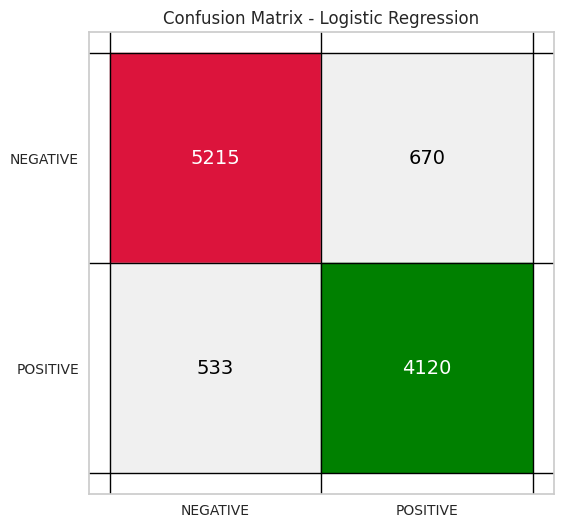

In [24]:
# --- Confusion Matrix with custom coloring ---

# Compute confusion matrix with class labels
cm = confusion_matrix(y_test_str, y_pred, labels=best_model.classes_)

fig, ax = plt.subplots(figsize=(6,6))

# Initialize color matrix (default light gray)
colors = np.full(cm.shape, '#f0f0f0')

# Define indices for positive and negative classes (assumed binary classification)
pos_class = 1  # index for positive class
neg_class = 0  # index for negative class

# Color True Positives green and True Negatives red
colors[pos_class, pos_class] = '#008000'  # green
colors[neg_class, neg_class] = '#DC143C'  # crimson/red

# Draw colored cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.fill_between([j, j+1], i, i+1, color=colors[i, j])

# Add counts with contrasting text color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if colors[i,j] in ['#008000', '#DC143C'] else 'black'
        ax.text(j + 0.5, i + 0.5, cm[i, j], ha='center', va='center', color=text_color, fontsize=14)

# Set axis ticks and labels
ax.set_xticks(np.arange(len(best_model.classes_)) + 0.5)
ax.set_xticklabels(best_model.classes_)
ax.set_yticks(np.arange(len(best_model.classes_)) + 0.5)
ax.set_yticklabels(best_model.classes_)

# Remove grid lines and add borders around cells
ax.grid(False)
for i in range(len(best_model.classes_) + 1):
    ax.axhline(i, color='black', linewidth=1)
    ax.axvline(i, color='black', linewidth=1)

ax.invert_yaxis()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

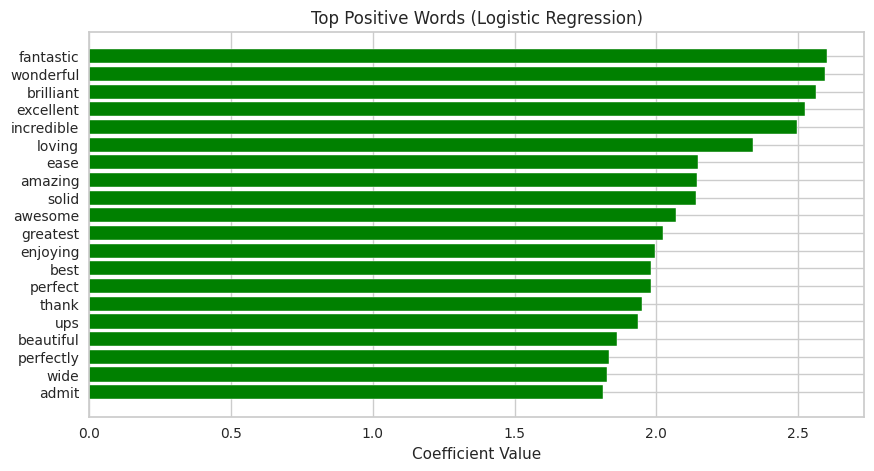

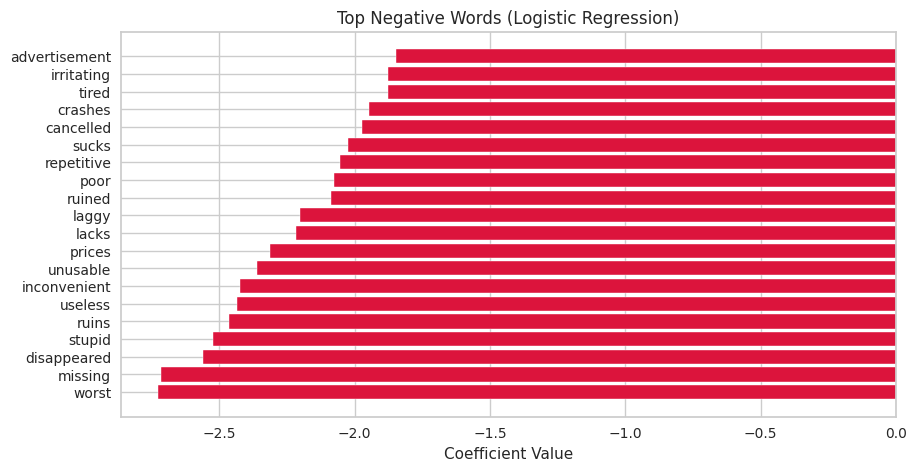

In [25]:
# === INTERPRET MODEL COEFFICIENTS (FEATURE IMPORTANCE) ===

feature_names = vectorizer.get_feature_names_out()
coefficients = best_model.coef_[0]  # for binary classification

# Get top 20 positive and negative coefficients (words)
top_positive_coeffs = np.argsort(coefficients)[-20:]
top_negative_coeffs = np.argsort(coefficients)[:20]

# Plot top positive words
plt.figure(figsize=(10, 5))
plt.barh(np.array(feature_names)[top_positive_coeffs], coefficients[top_positive_coeffs], color='#008000')
plt.title("Top Positive Words (Logistic Regression)")
plt.xlabel("Coefficient Value")
plt.show()

# Plot top negative words
plt.figure(figsize=(10, 5))
plt.barh(np.array(feature_names)[top_negative_coeffs], coefficients[top_negative_coeffs], color='#DC143C')
plt.title("Top Negative Words (Logistic Regression)")
plt.xlabel("Coefficient Value")
plt.show()

In [26]:
# === CROSS-VALIDATION ===

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_bow, y_str, cv=cv, scoring='accuracy')

print("Cross-validated Accuracy Scores:", scores)
print("Mean Accuracy:", np.mean(scores))


Cross-validated Accuracy Scores: [0.88413361 0.88791876 0.87890291 0.88554617 0.88288887]
Mean Accuracy: 0.8838780652251742


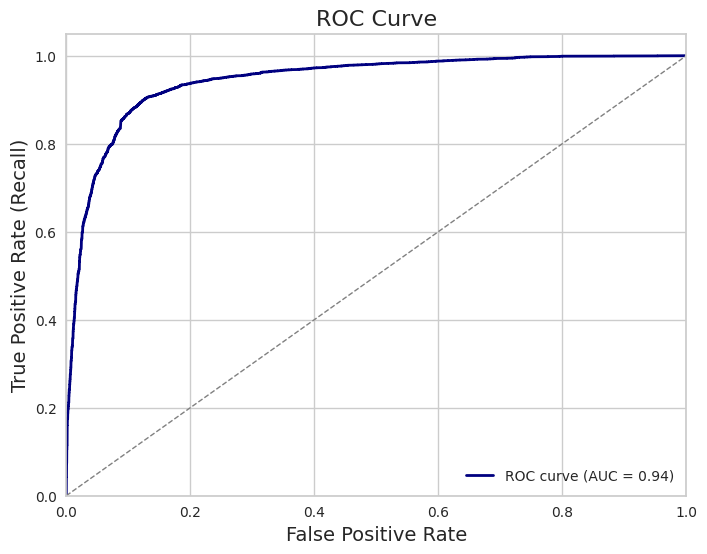

In [27]:
# === ROC CURVE AND AUC ===

# Map string labels to binary for metrics
label_map = {'NEGATIVE': 0, 'POSITIVE': 1}
y_test_bin = y_test_str.map(label_map)

# Predict probabilities for positive class
y_scores = best_model.predict_proba(X_test_bow_str)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_bin, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#000080', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate (Recall)', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

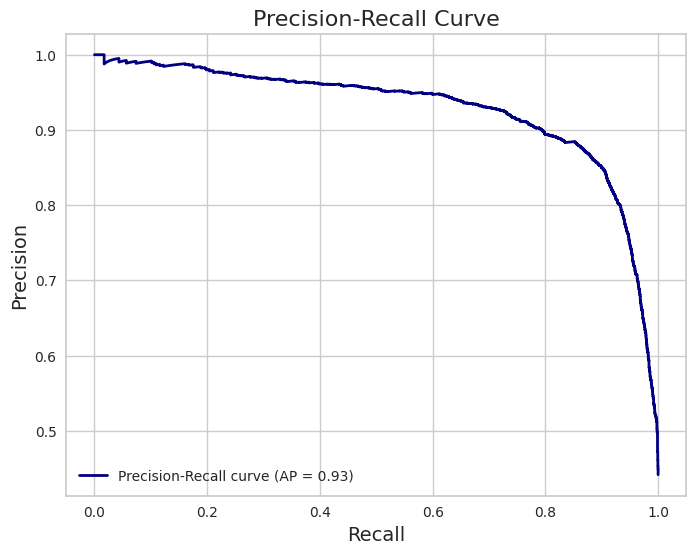

In [28]:
# === PRECISION-RECALL CURVE AND AVERAGE PRECISION ===

precision, recall, _ = precision_recall_curve(y_test_bin, y_scores)
avg_precision = average_precision_score(y_test_bin, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='#000080', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

## **Inference-Using Model For New Samples**

In [29]:
# === INFERENCE ON NEW SAMPLES USING TRAINED MODEL ===

# New raw reviews to classify
new_reviews = [
    "I love this app! It's amazing and works perfectly.",
    "This is the worst app I have ever used. Absolutely terrible.",
    "Quite decent, but it could be better. Some features are missing.",
    "This app is absolutely terrible, I really don’t like it",
    "Nice",
    "Completely disgusting",
    "Not 100% perfect, but still the best streaming app",
    "Best app ever, I like the idea!!KS"
]

# 1. Clean the new reviews using the previously defined clean_text function
new_reviews_cleaned = [clean_text(review) for review in new_reviews]

# 2. Vectorize cleaned reviews using the same CountVectorizer from training
new_reviews_bow = vectorizer.transform(new_reviews_cleaned)

# 3. Predict sentiment labels using the trained logistic regression model
predicted_labels = best_model.predict(new_reviews_bow)

# 4. Display each review with its predicted sentiment
for review, label in zip(new_reviews, predicted_labels):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {label}")
    print("-" * 50)


Review: I love this app! It's amazing and works perfectly.
Predicted Sentiment: POSITIVE
--------------------------------------------------
Review: This is the worst app I have ever used. Absolutely terrible.
Predicted Sentiment: NEGATIVE
--------------------------------------------------
Review: Quite decent, but it could be better. Some features are missing.
Predicted Sentiment: NEGATIVE
--------------------------------------------------
Review: This app is absolutely terrible, I really don’t like it
Predicted Sentiment: NEGATIVE
--------------------------------------------------
Review: Nice
Predicted Sentiment: POSITIVE
--------------------------------------------------
Review: Completely disgusting
Predicted Sentiment: NEGATIVE
--------------------------------------------------
Review: Not 100% perfect, but still the best streaming app
Predicted Sentiment: POSITIVE
--------------------------------------------------
Review: Best app ever, I like the idea!!KS
Predicted Sentiment: PO

## **Text Clustering**

In [22]:
# === IMPORTS ===
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud

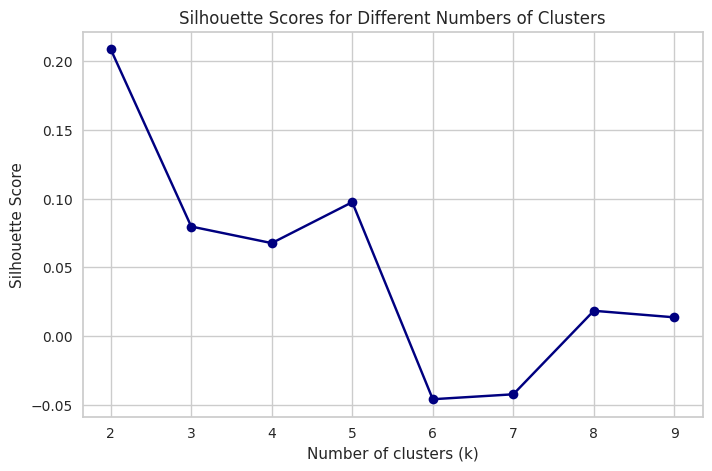

In [30]:
# === 1) Determine Optimal Number of Clusters Using Silhouette Score ===

silhouette_scores = []  # Silhouette scores for each k
k_range = range(2, 10)  # Range of cluster numbers to test

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_bow)
    silhouette_scores.append(silhouette_score(X_bow, labels))

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', color='#000080')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [31]:
# === 2) Fit KMeans with chosen number of clusters and assign to data ===

optimal_k = 2  # Choose based on above plots or domain knowledge
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_bow)

# Add cluster labels to the dataframe for further analysis
data_cleaned['cluster'] = clusters


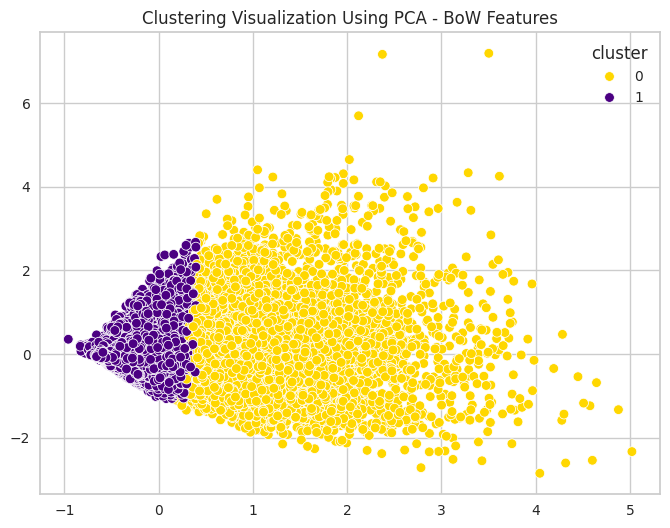

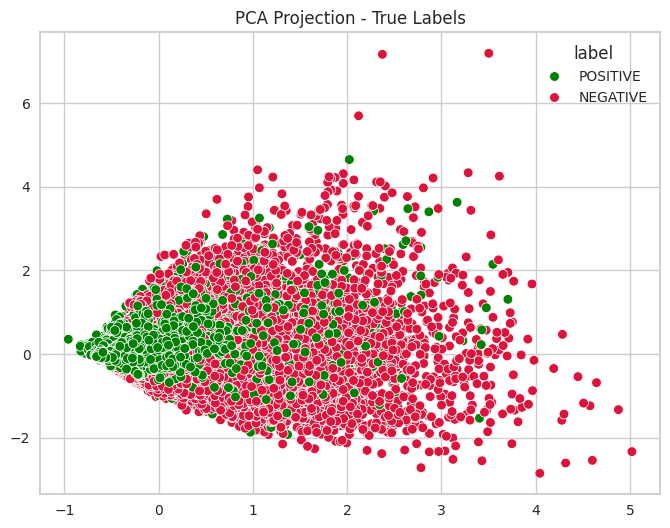

In [32]:
# === 3) Visualize Clusters with PCA ===

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_bow.toarray())  # Convert sparse to dense for PCA

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=data_cleaned['cluster'],
    palette=['#FFD700', '#4B0082'],
    legend='full'
)
plt.title("Clustering Visualization Using PCA - BoW Features")
plt.show()

# Visualize true labels on PCA components for comparison
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=data_cleaned['label'],
    palette={'POSITIVE': '#008000', 'NEGATIVE': '#DC143C'},
    legend='full'
)
plt.title("PCA Projection - True Labels")
plt.show()



In [33]:
# === 4) Evaluate Clustering Quality ===

# Silhouette score for final clusters
sil_score = silhouette_score(X_bow, clusters)
print(f"Silhouette Score (k={optimal_k}): {sil_score:.3f}")

# Adjusted Rand Index (external metric comparing clusters to true labels)
ari = adjusted_rand_score(data_cleaned['label'], clusters)
print(f"Adjusted Rand Index: {ari:.4f}")

# Normalized Mutual Information (external metric comparing clusters to true labels)
nmi = normalized_mutual_info_score(data_cleaned['label'], clusters)
print(f"Normalized Mutual Information: {nmi:.4f}")

Silhouette Score (k=2): 0.209
Adjusted Rand Index: 0.0496
Normalized Mutual Information: 0.1063


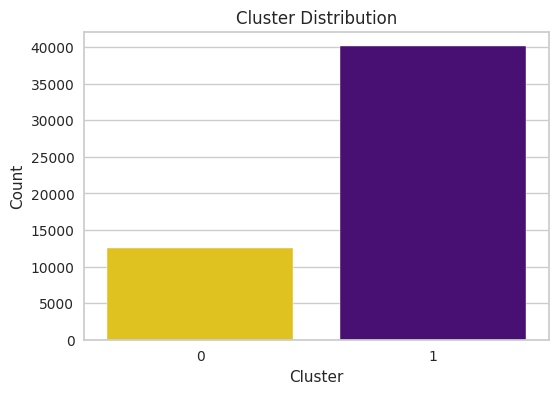

cluster
1    40103
0    12583
Name: count, dtype: int64


In [34]:
# === 5) Cluster Distribution Plot ===

plt.figure(figsize=(6, 4))
sns.countplot(x=clusters, palette=['#FFD700', '#4B0082'])
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

# Show distribution as a pandas Series
cluster_distribution = data_cleaned['cluster'].value_counts()
print(cluster_distribution)

In [35]:
# === 6) Cross-tabulation of Clusters vs True Labels ===

ct = pd.crosstab(data_cleaned['label'], data_cleaned['cluster'], margins=True)
print(ct)


cluster       0      1    All
label                        
NEGATIVE  10867  18556  29423
POSITIVE   1716  21547  23263
All       12583  40103  52686


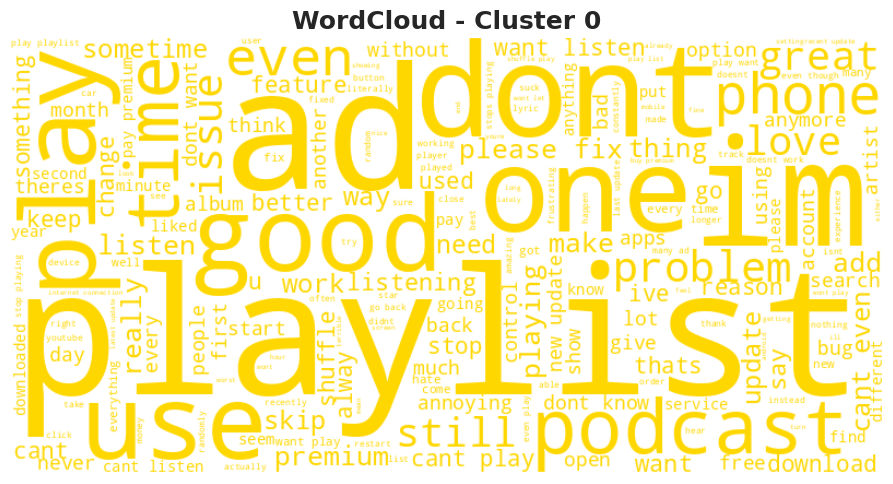

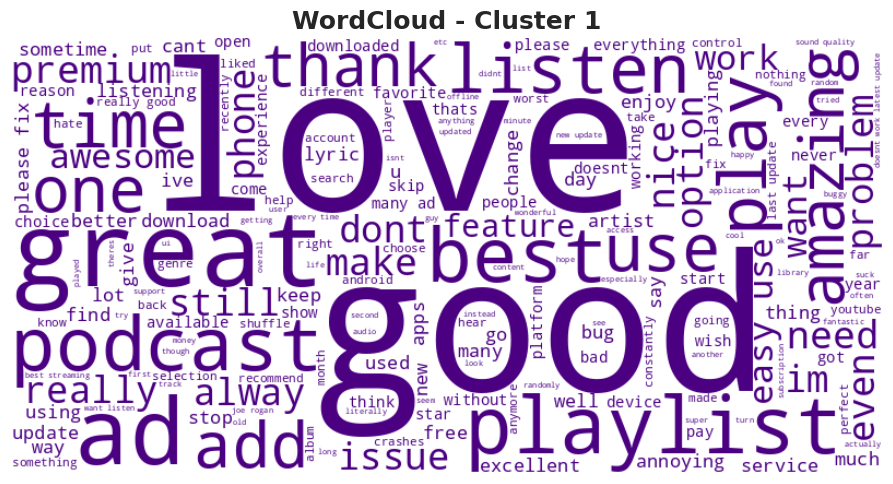

In [36]:
# === 7) Generate WordClouds for Each Cluster ===

cluster_colors = ['#FFD700', '#4B0082']
n_clusters = data_cleaned['cluster'].nunique()

for i in range(n_clusters):
    # Combine all cleaned reviews belonging to the current cluster
    cluster_text = ' '.join(data_cleaned[data_cleaned['cluster'] == i]['Cleaned_Review'])

    # Generate word cloud
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        width=800,
        height=400,
        contour_width=2,
        contour_color='black'
    ).generate(cluster_text)

    # Plot word cloud with cluster-specific color
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud.recolor(color_func=lambda *args, **kwargs: cluster_colors[i % len(cluster_colors)]),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - Cluster {i}", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

vecchii

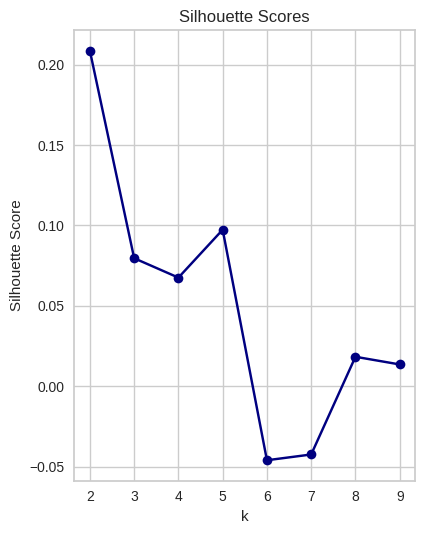

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
silhouette_scores = []
k_range = range(2, 10)  # puoi estendere se vuoi

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_bow)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_bow, labels))

# Plot Silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='#000080')
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

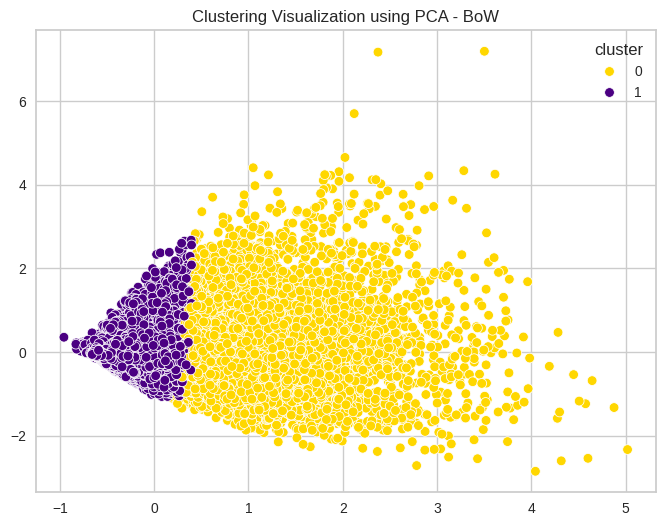

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_bow)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data_cleaned['cluster'], palette=['#FFD700', '#4B0082'])
plt.title("Clustering Visualization using PCA - BoW")
plt.show()

Text(0.5, 1.0, 'PCA - True Labels')

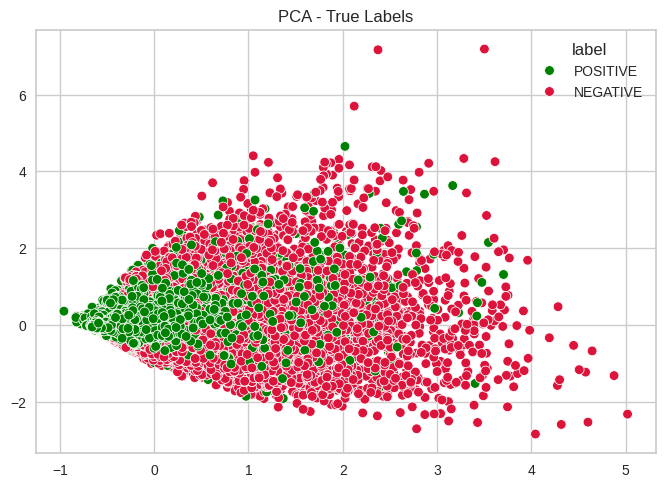

In [ ]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data_cleaned['label'],
                palette={'POSITIVE': '#008000', 'NEGATIVE': '#DC143C'})
plt.title("PCA - True Labels")

In [ ]:
from sklearn.metrics import silhouette_score
# Calcolo del Silhouette Score
score = silhouette_score(X_bow, clusters)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.209


In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(data_cleaned['label'], clusters)
nmi = normalized_mutual_info_score(data_cleaned['label'], clusters)

print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")


Adjusted Rand Index: 0.0496
Normalized Mutual Information: 0.1063


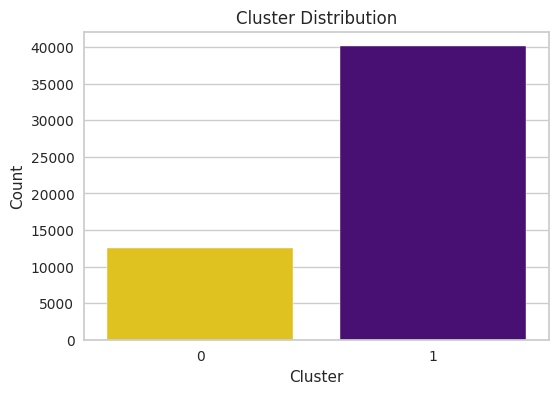

In [ ]:
# --- Plot distribuzione cluster ---
plt.figure(figsize=(6,4))
sns.countplot(x=clusters, palette=['#FFD700', '#4B0082'])
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

In [ ]:
# Cluster distribution
cluster_distribution = data_cleaned['cluster'].value_counts()
cluster_distribution

,count
cluster,
1,40103
0,12583


Text(0.5, 1.0, 'PCA - True Labels')

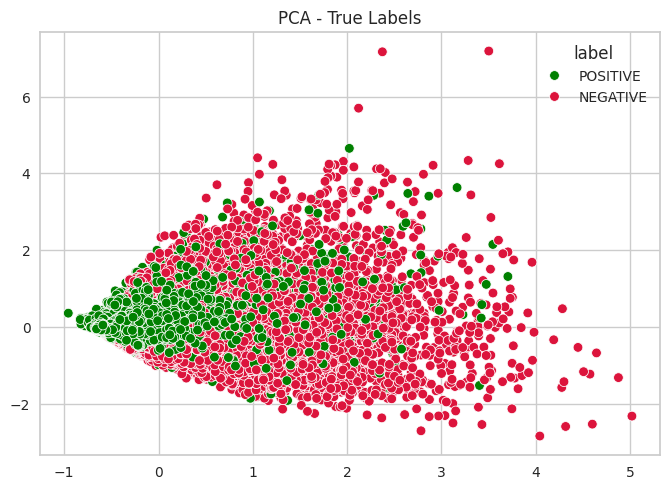

In [ ]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data_cleaned['label'],
                palette={'POSITIVE': '#008000', 'NEGATIVE': '#DC143C'})
plt.title("PCA - True Labels")


In [ ]:
pd.crosstab(data_cleaned['label'], data_cleaned['cluster'], margins=True)


cluster,0,1,All
label,,,
NEGATIVE,10867,18556,29423
POSITIVE,1716,21547,23263
All,12583,40103,52686


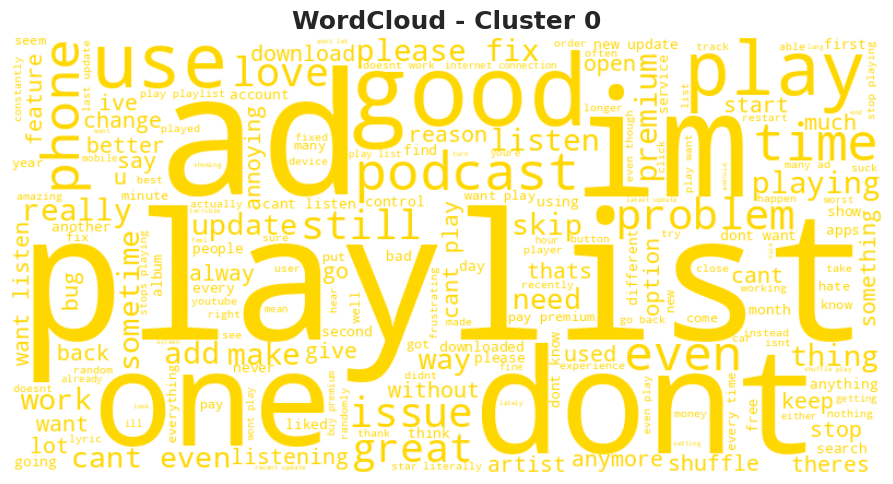

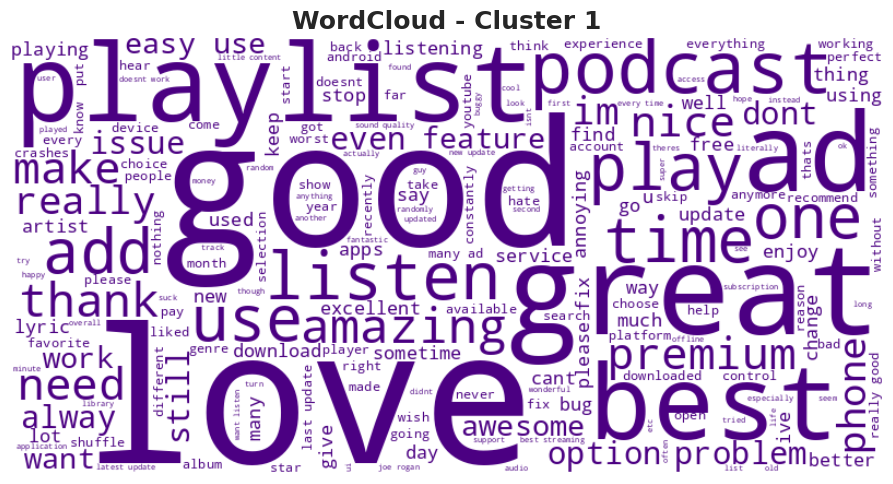

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Colori diversi per ogni cluster (puoi personalizzarli)
cluster_colors = ['#FFD700', '#4B0082', '#00CED1', '#FF69B4', '#32CD32']  # se usi >2 cluster, aggiungi colori

# Numero di cluster unici
n_clusters = data_cleaned['cluster'].nunique()

# Genera WordCloud per ciascun cluster
for i in range(n_clusters):
    cluster_text = ' '.join(data_cleaned[data_cleaned['cluster'] == i]['Cleaned_Review'])

    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        width=800,
        height=400,
        contour_width=2,
        contour_color='black'
    ).generate(cluster_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud.recolor(color_func=lambda *args, **kwargs: cluster_colors[i % len(cluster_colors)]),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - Cluster {i}", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
